# Analysis of PPE Need Across the USA
Results of Demand Side GetUsPPE Study - Launched April 3rd, 2020

In [88]:
# import data and packages
import json, requests
import configparser
import os, sys, time
import os.path as path

# computing
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import us
from uszipcode import SearchEngine
import plotly.graph_objects as go
from plotly.offline import plot
sns.set()

### Download survey data

In [52]:
# File has to be turned to view only to work - FYI
survey_url = 'https://docs.google.com/spreadsheet/ccc?key=1YspvIHEjK2PnTHf_YePQX-i3HeGEqgbBxIJlRLsMkZ0&output=csv'

survey = pd.read_csv(survey_url, error_bad_lines=False)
survey.head(5)

,Respondent ID,Collector ID,Start Date,End Date,IP Address,Email Address,First Name,Last Name,Custom Data 1,Correct Email,...,Drop Off Address,Drop Off Address 2,Drop Off City,Drop Off State,Drop Off Zip,Drop Off Country,Drop Off Email,Drop Off Phone,Drop Off Instructions,Other
0,11476056530,257559888,2020-04-04 10:47:40,2020-04-04 10:50:43,73.58.238.110,NaN,NaN,NaN,NaN,Yes,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,11476006849,257559888,2020-04-04 10:18:34,2020-04-04 10:22:40,67.180.110.145,NaN,NaN,NaN,NaN,Yes,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,11475968497,257559888,2020-04-04 10:01:41,2020-04-04 10:06:14,134.192.250.46,NaN,NaN,NaN,NaN,No (please specify correct email),...,8108 Foxberry Ln,Apt 1513,Pasadena,MD,21122,NaN,NaN,410-212-8812,"if you send to my apartment, i can easily get ...",NaN
3,11475727034,257559888,2020-04-04 07:39:08,2020-04-04 07:51:33,75.189.132.158,NaN,NaN,NaN,NaN,Yes,...,1801 doctors dr,NaN,sanford,NC,27330,United States,NaN,9193601290,monday - friday 8:30-4pm,Please help us be able to continue to see our ...
4,11475627496,257559888,2020-04-04 06:33:25,2020-04-04 06:41:13,67.241.42.1,NaN,NaN,NaN,NaN,Yes,...,1500 north James street,NaN,Rome,NY,13440,NaN,NaN,3153387000,"Any day any time, main lobby",NaN


### Data Cleaning

In [53]:
# Make sure zip codes have leading zeros.
survey['Zip'] = survey['Zip'].apply(lambda x: '{0:0>5}'.format(x))
# Only use the first five digits so it's a valid zipcode
survey['Zip'] = survey['Zip'].astype(str).str[0:5]

In [54]:
# Some string fields have formatting issues.
columns = survey.select_dtypes(include='object').columns
for column in columns:
    survey[column] = survey[column].str.replace('\xa0', ' ')

In [55]:
ppes = ['N95', 'Surgical Mask', 'Face Shield', 'Booties', 'Gloves', 'Gown', 
        'Sanitizer', 'Wipes', 'Thermometer', 'Homemade Mask', 'Other']

In [56]:
for ppe in ppes:
    percent_filled_out = 100 * (1 - np.mean(pd.isnull(survey['Requesting {}'.format(ppe)])))
    print("{:.1f}% left an answer for whether they need {}.".format(percent_filled_out, ppe))

86.5% left an answer for whether they need N95.
14.6% left an answer for whether they need Surgical Mask.
82.8% left an answer for whether they need Face Shield.
82.0% left an answer for whether they need Booties.
81.9% left an answer for whether they need Gloves.
81.6% left an answer for whether they need Gown.
81.6% left an answer for whether they need Sanitizer.
81.4% left an answer for whether they need Wipes.
81.0% left an answer for whether they need Thermometer.
80.9% left an answer for whether they need Homemade Mask.
80.9% left an answer for whether they need Other.


### Determine number of institutions needing different types of PPE

##### Survey Notes
- For now, drop 'Surgical Mask' because there was a bug in the survey.
- Also dropping homemade mask as this is not the default want (I think it biased the answer high)
- Dropping 'Other' for main analysis



In [117]:
# types of PPE to consider
ppes = ['N95', 'Face Shield', 'Booties', 'Gloves', 'Gown', 
        'Sanitizer', 'Wipes', 'Thermometer']

# Remove all rows which have null values for any of the PPEs/
valid_requests = survey
for ppe in ppes:
    valid_requests = valid_requests[valid_requests['Requesting {}'.format(ppe)].notnull()]
    valid_requests['Requesting {}'.format(ppe)] = valid_requests[
        'Requesting {}'.format(ppe)].replace({'Yes': True, 'No': False})

/Users/mrubash1/.pyenv/versions/miniconda3-4.7.12/envs/getusppe/lib/python3.7/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [124]:
# Still keeping 81% of DF, probably about the best we could do.
percent_survey_used = len(valid_requests) / len(survey)
print ('Percent of total survey valid: %s\n' % (percent_survey_used))

print ('Of the valid survey entries, they needed:')
for ppe in ppes:
    percent_needing_ppe = 100 * np.mean(valid_requests['Requesting {}'.format(ppe)].astype(int))
    print("{:.1f}% of respondents need {}.".format(percent_needing_ppe, ppe))

Percent of total survey valid: 0.8101449275362319

Of the valid survey entries, they needed:
83.0% of respondents need N95.
73.3% of respondents need Face Shield.
38.8% of respondents need Booties.
52.8% of respondents need Gloves.
77.6% of respondents need Gown.
72.1% of respondents need Sanitizer.
73.2% of respondents need Wipes.
48.5% of respondents need Thermometer.


### Plot pie chart

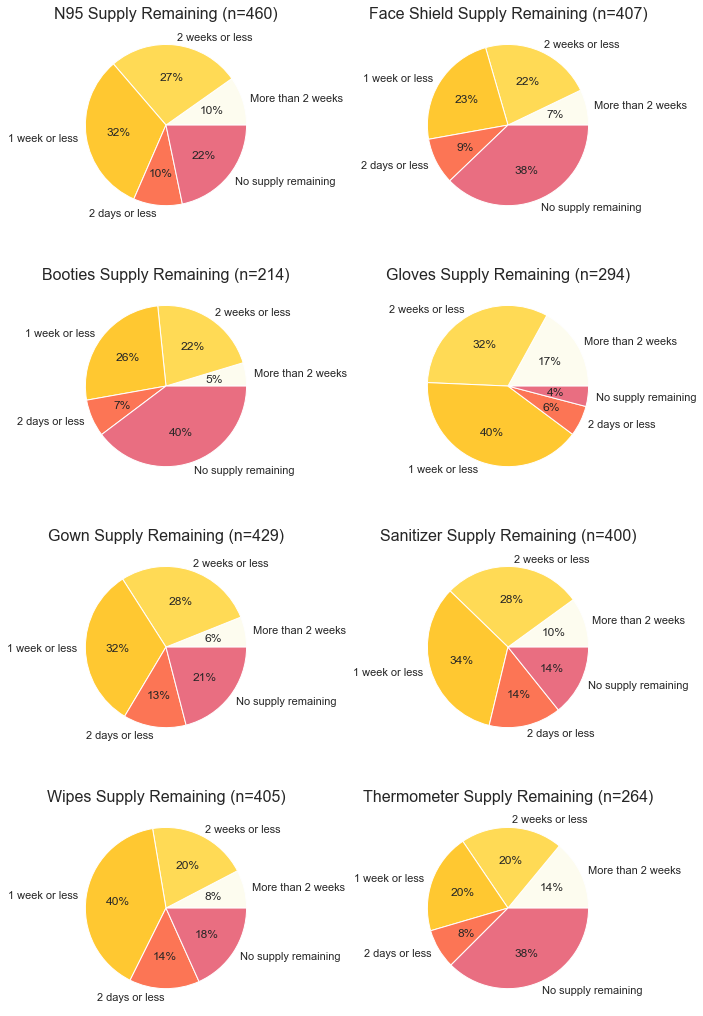

In [39]:
fig, axs = plt.subplots(4, 2, figsize=(10, 15))
fig.tight_layout(pad=3.0)
order = [3, 2, 0, 1, 4]
count = 0
colors = ["#FDFCEF","#FFDA55","#FFC831","#FC7555","#E96E81"]
for ppe in ppes:
    ppe_stock = np.array(valid_requests[~pd.isnull(valid_requests['{} Stock'.format(ppe)])]['{} Stock'.format(ppe)])
    ppe_unique, ppe_counts = np.unique(ppe_stock, return_counts=True)
    labels = ppe_unique[order]
    percentages = (ppe_counts / np.sum(ppe_counts) * 100)[order]
    axs[count // 2, count % 2].pie(percentages, labels=labels, colors=colors, autopct='%1.0f%%')
    axs[count // 2, count % 2].set_title("{} Supply Remaining (n={})".format(ppe, len(ppe_stock)), size=16)
    count += 1
plt.savefig("supplies_remaining.png", dpi=200, bbox_to_anchor='tight')

### Create new dataframe with just stock of items of interest

In [102]:
# Pull stock of items out of survey datafarme
item_stock_df = survey[[
    'Requesting N95',
    'N95 Stock', 
    'Requesting Face Shield',
    'Face Shield Stock',
    'Requesting Booties',
    'Booties Stock',
    'Requesting Gloves',
    'Gloves Stock',
    'Requesting Gown',
    'Gown Stock',
    'Requesting Sanitizer',
    'Sanitizer Stock',
    'Requesting Wipes',
    'Wipes Stock',
    'Requesting Thermometer',
    'Thermometer Stock',
    'Zip']]

# Map the stock from ordinal to numerical
mapping = {'No supply remaining': 0,
           '2 days or less': 2, 
           '1 week or less': 7,
           '2 weeks or less': 14,
           'More than 2 weeks': 28,
           'Zip': 'Zip',
           'Yes':True,
           'No': False}

item_stock_numberical_df=item_stock_df.replace({
    'Requesting N95':mapping,
    'N95 Stock':mapping, 
    'Requesting Face Shield':mapping,
    'Face Shield Stock':mapping,
    'Requesting Booties':mapping,
    'Booties Stock':mapping,
    'Requesting Gloves':mapping,
    'Gloves Stock':mapping,
    'Requesting Gown':mapping,
    'Gown Stock':mapping,
    'Requesting Sanitizer':mapping,
    'Sanitizer Stock':mapping,
    'Requesting Wipes':mapping,
    'Wipes Stock':mapping,
    'Requesting Thermometer':mapping,
    'Thermometer Stock':mapping,
    'Zip':mapping
    })

item_stock_numberical_df.head(5)

,Requesting N95,N95 Stock,Requesting Face Shield,Face Shield Stock,Requesting Booties,Booties Stock,Requesting Gloves,Gloves Stock,Requesting Gown,Gown Stock,Requesting Sanitizer,Sanitizer Stock,Requesting Wipes,Wipes Stock,Requesting Thermometer,Thermometer Stock,Zip
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,37232
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,95110
2,True,NaN,False,NaN,False,NaN,False,NaN,False,NaN,True,7.0,True,7.0,False,NaN,21201
3,True,0.0,False,NaN,False,NaN,True,14.0,True,14.0,True,14.0,True,14.0,True,14.0,27330
4,True,7.0,True,0.0,True,7.0,False,NaN,True,7.0,True,28.0,False,NaN,False,NaN,13440


### Map the zip code to state

In [103]:
# zfill the fips to make sure they are right
width=5
item_stock_numberical_df["Zip"]= item_stock_numberical_df["Zip"].astype(str)
item_stock_numberical_df["Zip"]= item_stock_numberical_df["Zip"].str.zfill(width) 


# Leverage uszipcode package
search = SearchEngine()
search = SearchEngine(simple_zipcode=True)
zipcode = search.by_zipcode("10001")

item_stock_numberical_df['State'] = item_stock_numberical_df.apply(
        lambda x: (search.by_zipcode(x['Zip']).state), axis=1)
item_stock_numberical_df.head(5)

,Requesting N95,N95 Stock,Requesting Face Shield,Face Shield Stock,Requesting Booties,Booties Stock,Requesting Gloves,Gloves Stock,Requesting Gown,Gown Stock,Requesting Sanitizer,Sanitizer Stock,Requesting Wipes,Wipes Stock,Requesting Thermometer,Thermometer Stock,Zip,State
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,37232,TN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,95110,CA
2,True,NaN,False,NaN,False,NaN,False,NaN,False,NaN,True,7.0,True,7.0,False,NaN,21201,MD
3,True,0.0,False,NaN,False,NaN,True,14.0,True,14.0,True,14.0,True,14.0,True,14.0,27330,NC
4,True,7.0,True,0.0,True,7.0,False,NaN,True,7.0,True,28.0,False,NaN,False,NaN,13440,NY


### Caluclate the mean amount of supply per facility

In [237]:
def requests_per_state(item_stock_numberical_df):
    
    # Count the amount of requests per county
    item_average_supply_per_state_df=item_stock_numberical_df.groupby(
        ['State']).mean()
        
    # Determine how many responses were captured from each state
    count_supply_per_state_df = item_stock_numberical_df.groupby(
        ['State']).count()
    
    # trim the return to 2 decimal points max
    return item_average_supply_per_state_df.round(decimals=2), \
        count_supply_per_state_df


item_average_supply_per_state_df, count_supply_per_state_df = \
    requests_per_state(item_stock_numberical_df)
item_average_supply_per_state_df.head(5)

,N95 Stock,Face Shield Stock,Booties Stock,Gloves Stock,Gown Stock,Sanitizer Stock,Wipes Stock,Thermometer Stock
State,,,,,,,,
AL,6.00,0.50,2.33,21.00,2.80,14.00,8.75,0.00
AR,11.67,9.33,11.67,17.50,7.00,10.00,10.50,14.00
AZ,9.80,9.33,16.33,14.00,13.29,10.11,8.78,9.33
CA,11.60,8.10,5.80,12.71,9.26,10.91,7.61,8.14
CO,9.10,5.10,7.00,19.25,10.12,7.50,7.00,12.00


### TODO: Calculate percentage in each state that is reporting no supply of PPE 

In [239]:
# TODO
# Calculate percentage in each state that is reporting no supply of materials 
no_supply_per_state_df['N95 Stock'] = item_stock_numberical_df[
    item_stock_numberical_df['N95 Stock']  == 0].groupby(['State']).count()

no_supply_per_state_df.head(5)

,Requesting N95,N95 Stock,Requesting Face Shield,Face Shield Stock,Requesting Booties,Booties Stock,Requesting Gloves,Gloves Stock,Requesting Gown,Gown Stock,Requesting Sanitizer,Sanitizer Stock,Requesting Wipes,Wipes Stock,Requesting Thermometer,Thermometer Stock,Zip
State,,,,,,,,,,,,,,,,,
AL,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
AZ,4,4,4,3,4,1,4,3,4,1,4,3,4,3,4,1,4
CA,6,6,6,5,6,3,6,4,6,5,6,4,6,4,6,4,6
CO,2,2,2,2,2,2,2,1,2,1,2,2,2,2,2,1,2
CT,3,3,3,3,3,2,3,1,3,2,3,2,3,3,3,2,3


### Check how many entries available per ppe supply

In [240]:
def join_mean_count_per_state(item_average_supply_per_state_df,
                          count_supply_per_state_df, write_out_csv=True):
    
    # join the counts with the days available
    supply_per_state_df = item_average_supply_per_state_df.join(
        count_supply_per_state_df, on='State', 
        how='left', lsuffix='', rsuffix=' Surveys')
    
    # write out this data file to csv
    if write_out_csv:
        timestr = time.strftime("%Y%m%d")
        path = 'supply_per_state_df_' + timestr + '.csv'
        supply_per_state_df.to_csv (path, index = False, header=True)
        
    # Drop any state that does not have 3 or more surveys
    cutoff_survey_number = 1
    indexNames = supply_per_state_df[ 
        supply_per_state_df['N95 Stock Surveys'] < cutoff_survey_number ].index

    # Delete these row indexes from dataFrame
    supply_per_state_df.drop(indexNames , inplace=True)
    
    return supply_per_state_df

supply_per_state_df = join_mean_count_per_state(item_average_supply_per_state_df,
                          count_supply_per_state_df, write_out_csv=True)
supply_per_state_df.head(5)

,N95 Stock,Face Shield Stock,Booties Stock,Gloves Stock,Gown Stock,Sanitizer Stock,Wipes Stock,Thermometer Stock,Requesting N95,N95 Stock Surveys,...,Gloves Stock Surveys,Requesting Gown,Gown Stock Surveys,Requesting Sanitizer,Sanitizer Stock Surveys,Requesting Wipes,Wipes Stock Surveys,Requesting Thermometer,Thermometer Stock Surveys,Zip
State,,,,,,,,,,,,,,,,,,,,,
AL,6.00,0.50,2.33,21.00,2.80,14.00,8.75,0.00,5,5,...,2,5,5,5,4,5,4,5,2,5
AR,11.67,9.33,11.67,17.50,7.00,10.00,10.50,14.00,3,3,...,2,3,2,3,3,3,2,3,2,3
AZ,9.80,9.33,16.33,14.00,13.29,10.11,8.78,9.33,12,10,...,6,11,7,11,9,11,9,11,3,12
CA,11.60,8.10,5.80,12.71,9.26,10.91,7.61,8.14,95,80,...,51,90,72,90,68,90,71,89,44,107
CO,9.10,5.10,7.00,19.25,10.12,7.50,7.00,12.00,14,10,...,8,13,8,13,8,13,9,13,7,17


### Create Text label for plot

In [241]:
# encode as string for the plot
supply_per_state_df = supply_per_state_df.astype(str)

# reset the index so state can be called
supply_per_state_df.reset_index(inplace=True)

supply_per_state_df['text'] = supply_per_state_df['State'] + '<br><br>' + \
    'Stock in Days: ' + '<br>' + \
    'N95: ' + supply_per_state_df['N95 Stock'] + '<br>' + \
    'Face Shields: ' + supply_per_state_df['Face Shield Stock'] + '<br>' + \
    'Booties: ' + supply_per_state_df['Booties Stock'] + '<br>' + \
    'Gloves: ' + supply_per_state_df['Gloves Stock'] + '<br>' + \
    'Gowns: ' + supply_per_state_df['Gown Stock'] + '<br>' + \
    'Sanitizers: ' + supply_per_state_df['Sanitizer Stock'] + '<br>' + \
    'Wipes: ' + supply_per_state_df['Wipes Stock'] + '<br>' + \
    'Thermometers: ' + supply_per_state_df['Thermometer Stock'] + '<br><br>' + \
    'Survey Responses: ' + supply_per_state_df['N95 Stock Surveys']

supply_per_state_df.head(2)

,State,N95 Stock,Face Shield Stock,Booties Stock,Gloves Stock,Gown Stock,Sanitizer Stock,Wipes Stock,Thermometer Stock,Requesting N95,...,Requesting Gown,Gown Stock Surveys,Requesting Sanitizer,Sanitizer Stock Surveys,Requesting Wipes,Wipes Stock Surveys,Requesting Thermometer,Thermometer Stock Surveys,Zip,text
0,AL,6.0,0.5,2.33,21.0,2.8,14.0,8.75,0.0,5,...,5,5,5,4,5,4,5,2,5,AL<br><br>Stock in Days: <br>N95: 6.0<br>Face ...
1,AR,11.67,9.33,11.67,17.5,7.0,10.0,10.5,14.0,3,...,3,2,3,3,3,2,3,2,3,AR<br><br>Stock in Days: <br>N95: 11.67<br>Fac...


### Supply by state

In [242]:
fig = go.Figure(data=go.Choropleth(
    locations=supply_per_state_df['State'],
    z=supply_per_state_df['N95 Stock'],
    locationmode='USA-states',
    colorscale=['#bc2026','#ef4723','#f68e1e','#fecc0a','#7dbb42','#0e9246'],
    autocolorscale=False,
    text=supply_per_state_df['text'], # hover text
    marker_line_color='black', # line markers between states
    marker_opacity=0.8, 
    marker_line_width=0.5,
    zmin=0,
    zmax=14,
    colorbar_title="N95 Supply (days)",
    hoverinfo='text'
))

fig.update_layout(
    title_text='Supply of PPE (N95s) in Days - Organizations Reaching out to GetUsPPE.org',
    geo = dict(
        scope='usa',
        projection=go.layout.geo.Projection(type = 'albers usa'),
        showlakes=True, # lakes
        lakecolor='rgb(255, 255, 255)'),
)

# Download the figure From Sunny Mui
go.Figure.write_html(fig, file='Available Supply of N95 in Days.html',
                     config={'responsive': True}, include_plotlyjs='cdn')

# Show the fig
fig.show()

In [243]:
fig = go.Figure(data=go.Choropleth(
    locations=supply_per_state_df['State'],
    z=supply_per_state_df['Face Shield Stock'],
    locationmode='USA-states',
    colorscale=['#bc2026','#ef4723','#f68e1e','#fecc0a','#7dbb42','#0e9246'],
    autocolorscale=False,
    text=supply_per_state_df['text'], # hover text
    marker_line_color='black', # line markers between states
    marker_opacity=0.8, 
    marker_line_width=0.5,
    zmin=0,
    zmax=14,
    colorbar_title="Face Shield Supply (days)",
    hoverinfo='text'
))

fig.update_layout(
    title_text='Supply of PPE (Face Shields) in Days - Organizations Reaching out to GetUsPPE.org',
    geo = dict(
        scope='usa',
        projection=go.layout.geo.Projection(type = 'albers usa'),
        showlakes=True, # lakes
        lakecolor='rgb(255, 255, 255)'),
)

# Download the figure From Sunny Mui
go.Figure.write_html(fig, file='Available Supply of Face Shields in Days.html',
                     config={'responsive': True}, include_plotlyjs='cdn')

# Show the fig
fig.show()